In [117]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

from statsmodels.graphics.tsaplots import plot_acf

from localreg import localreg, rbf

In [2]:
import sys
sys.path.append('../')  # go to parent dir
sys.path.append('/home/artem/git/sdafe-utils')

In [3]:
from ch11.utils import nelson_siegel_yield, nelson_siegel_forward

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter, Formula, FloatVector

np_cv_rules = default_converter + numpy2ri.converter

In [24]:
KernSmooth = importr('KernSmooth')
mgcv = importr('mgcv')

In [6]:
data = pd.read_csv('../data/Capm.csv', index_col=0)
data.head()

,rfood,rdur,rcon,rmrf,rf
1,-4.59,0.87,-6.84,-6.99,0.33
2,2.62,3.46,2.78,0.99,0.29
3,-1.67,-2.28,-0.48,-1.46,0.35
4,0.86,2.41,-2.02,-1.70,0.19
5,7.34,6.33,3.69,3.08,0.27


In [7]:
rf = data['rf']
rf.index = np.linspace(1960.125, 2003, len(rf))
rf_diff = rf.diff().dropna()
rf_lag = rf.shift().dropna()

In [46]:
def fit_linear_smooth(x, y):
    with np_cv_rules.context():
        bw = KernSmooth.dpill(x.values, y.values)[0]
        return KernelReg(y, x, var_type='c', bw=[bw]).fit()[0]    

In [47]:
rf_diff_sm = fit_linear_smooth(rf_lag, rf_diff)
epsilon_sqr = (rf_diff_sm - rf_diff) ** 2
epsilon_sqr_sm = fit_linear_smooth(rf_lag, epsilon_sqr)

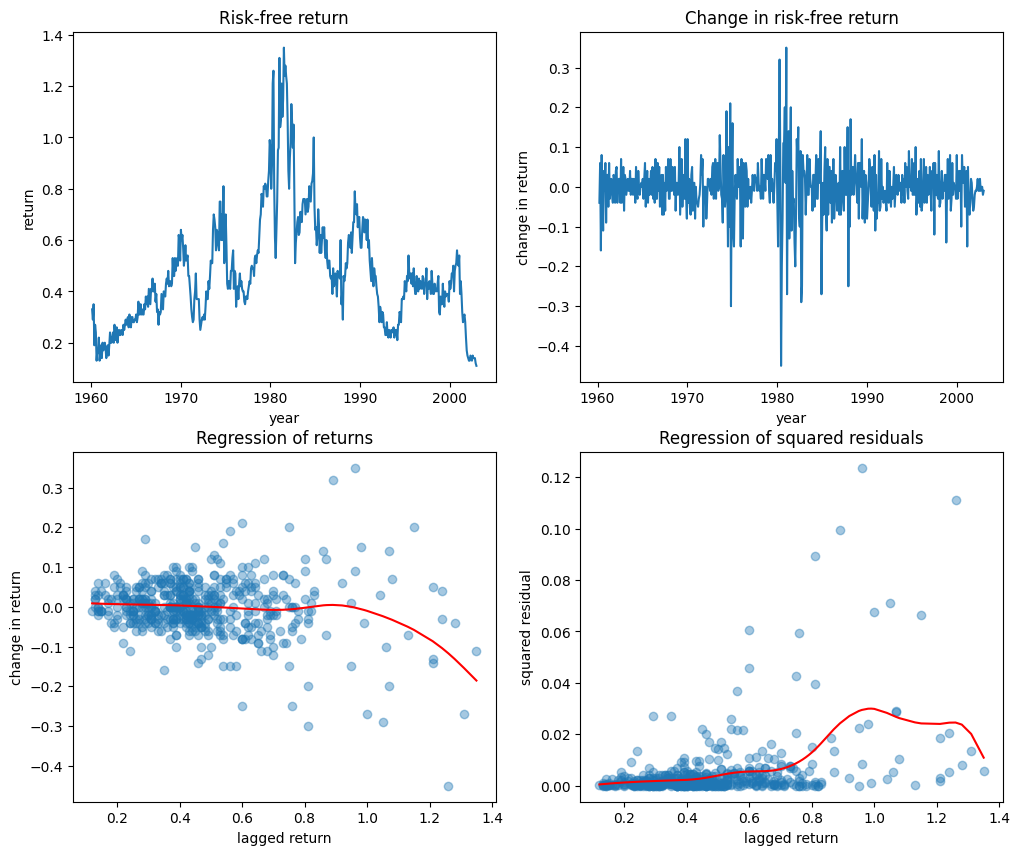

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0][0].plot(rf);
axs[0][0].set_title('Risk-free return');
axs[0][0].set_xlabel('year');
axs[0][0].set_ylabel('return');

axs[0][1].plot(rf_diff);
axs[0][1].set_title('Change in risk-free return');
axs[0][1].set_xlabel('year');
axs[0][1].set_ylabel('change in return');

axs[1][0].scatter(rf_lag, rf_diff, alpha=0.4);
axs[1][0].plot(np.sort(rf_lag), rf_diff_sm[np.argsort(rf_lag)], color='red');
axs[1][0].set_title('Regression of returns');
axs[1][0].set_xlabel('lagged return');
axs[1][0].set_ylabel('change in return');

axs[1][1].scatter(rf_lag, epsilon_sqr, alpha=0.4);
axs[1][1].plot(np.sort(rf_lag), epsilon_sqr_sm[np.argsort(rf_lag)], color='red');
axs[1][1].set_title('Regression of squared residuals');
axs[1][1].set_xlabel('lagged return');
axs[1][1].set_ylabel('squared residual');

#### Example 21.1 Local polynomial estimation of forward rates

In [49]:
data = pd.read_csv('../data/strips_dec95.txt', sep='\\s+').sort_values(by='T')
data.head()

,T,price
0,0.1260,99.393
39,0.3699,98.155
1,0.6219,96.924
40,0.8740,95.717
2,1.1260,94.511


In [50]:
T = data['T']
int_f = -np.log(data['price']) + np.log(100)
y = int_f / T

In [88]:
def fit_via_locfit(x, y, degree, deriv=None):
    importr('locfit')
    with robjects.local_context() as lc, np_cv_rules.context():
        lc['x'] = FloatVector(x)
        lc['y'] = FloatVector(y)
        if deriv is not None:
            return robjects.r(f'fitted(locfit(y ~ x, deriv={deriv}, deg={degree}))')
        else:
            return robjects.r(f'fitted(locfit(y ~ x, deg={degree}))')

In [63]:
log_reg_int_f = fit_via_locfit(T, int_f, 3, 1)

In [64]:
def obj_fun(theta):
    ns = theta[0] * T - theta[1] / theta[3] * (np.exp(-theta[3] * T) - 1) - theta[2] * (T * np.exp(-theta[3] * T) / theta[3] + (np.exp(-theta[3] * T) - 1) / theta[3] ** 2)
    #ns = nelson_siegel_yield(T, theta) * T
    return np.sum((int_f - ns) ** 2)

In [65]:
start = np.array([0.05, 0.001, 0.001, 0.08])
lower = np.array([-100, -100, -100, 0.0001])
upper = np.array([100, 100, 100, 100])
%time fit_NS = minimize(obj_fun, start, method='L-BFGS-B', bounds=list(zip(lower, upper)), options={'ftol': 1e-10}).x
fit_NS

CPU times: user 4.48 s, sys: 6.09 ms, total: 4.49 s
Wall time: 4.47 s


array([-0.98444281,  1.02911398,  0.01694379,  0.01326461])

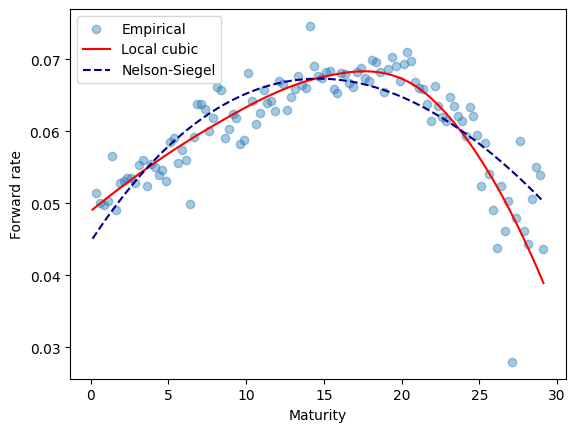

In [66]:
fig, ax = plt.subplots()
ax.scatter(T, int_f.diff() / T.diff(), alpha=0.4, label='Empirical');
ax.plot(T, log_reg_int_f, color='red', label='Local cubic')
ax.plot(T, nelson_siegel_forward(T, fit_NS), '--', color='darkblue', label='Nelson-Siegel');
ax.set_xlabel('Maturity');
ax.set_ylabel('Forward rate');
ax.legend();

#### Example 21.2 Estimating the drift and volatility for the evolution of the risk-free returns

In [67]:
data = pd.read_csv('../data/Capm.csv', index_col=0)
data.head()

,rfood,rdur,rcon,rmrf,rf
1,-4.59,0.87,-6.84,-6.99,0.33
2,2.62,3.46,2.78,0.99,0.29
3,-1.67,-2.28,-0.48,-1.46,0.35
4,0.86,2.41,-2.02,-1.70,0.19
5,7.34,6.33,3.69,3.08,0.27


In [68]:
rf = data['rf']
rf.index = np.linspace(1960.125, 2003, len(rf))
rf_diff = rf.diff().dropna()
rf_lag = rf.shift().dropna()

In [69]:
ll_mu = fit_linear_smooth(rf_lag, rf_diff)
epsilon_sqr = (rf_diff_sm - rf_diff) ** 2
ll_sig = fit_linear_smooth(rf_lag, epsilon_sqr)

In [70]:
def fit_gam_cubic(x, y):
    fmla = Formula('y ~ s(x, bs="cr")')
    fmla.environment['x'] = FloatVector(x)
    fmla.environment['y'] = FloatVector(y)
    with np_cv_rules.context():
        return mgcv.gam(fmla, method='REML')['fitted.values']

In [89]:
gam_mu = fit_gam_cubic(rf_lag, rf_diff)
epsilon_sqr = (rf_diff - gam_mu) ** 2
gam_sig = fit_gam_cubic(rf_lag, epsilon_sqr)

In [90]:
locfit_mu = fit_via_locfit(rf_lag, rf_diff, 2)
epsilon_sqr = (rf_diff - locfit_mu) ** 2
locfit_sig = fit_via_locfit(rf_lag, epsilon_sqr, 2)

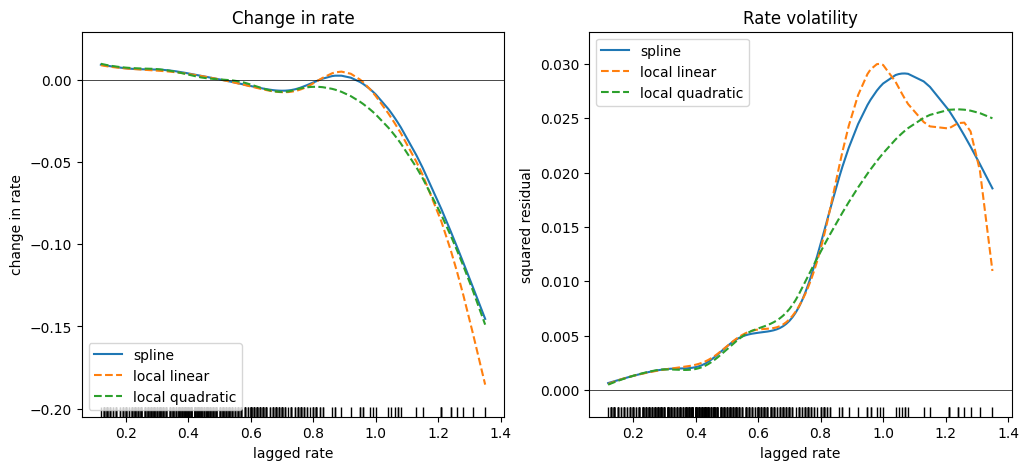

In [112]:
order = np.argsort(rf_lag.values)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(rf_lag.iloc[order], gam_mu[order], label='spline');
axs[0].plot(rf_lag.iloc[order], ll_mu[order], '--', label='local linear');
axs[0].plot(rf_lag.iloc[order], locfit_mu[order], '--', label='local quadratic');
sns.rugplot(rf_lag, ax=axs[0], color='black');
axs[0].axhline(0, color='black', linewidth=0.5);
axs[0].set_title('Change in rate');
axs[0].set_xlabel('lagged rate');
axs[0].set_ylabel('change in rate');
axs[0].legend();

axs[1].plot(rf_lag.iloc[order], gam_sig[order], label='spline');
axs[1].plot(rf_lag.iloc[order], ll_sig[order], '--', label='local linear');
axs[1].plot(rf_lag.iloc[order], locfit_sig[order], '--', label='local quadratic');
sns.rugplot(rf_lag, ax=axs[1], color='black');
axs[1].axhline(0, color='black', linewidth=0.5);
axs[1].set_title('Rate volatility');
axs[1].set_xlabel('lagged rate');
axs[1].set_ylabel('squared residual');
axs[1].legend();

In [113]:
std_res = (rf_diff - locfit_mu) / np.sqrt(locfit_sig)

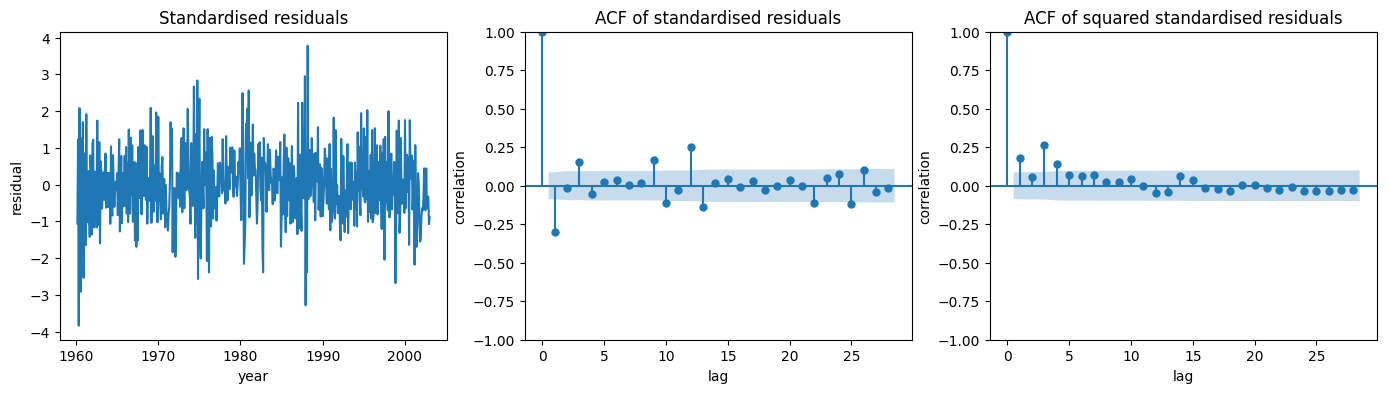

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

axs[0].plot(std_res);
axs[0].set_xlabel('year');
axs[0].set_ylabel('residual');
axs[0].set_title('Standardised residuals');

plot_acf(std_res, ax=axs[1]);
axs[1].set_title('ACF of standardised residuals');
axs[1].set_xlabel('lag');
axs[1].set_ylabel('correlation');

plot_acf(std_res ** 2, ax=axs[2]);
axs[2].set_title('ACF of squared standardised residuals');
axs[2].set_xlabel('lag');
axs[2].set_ylabel('correlation');

#### Example 21.3 Spline estimation of a forward rate

In [124]:
data = pd.read_csv('../data/strips_dec95.txt', sep='\\s+').sort_values(by='T')
data.head()

,T,price
0,0.1260,99.393
39,0.3699,98.155
1,0.6219,96.924
40,0.8740,95.717
2,1.1260,94.511


In [126]:
T = data['T']
int_f = -np.log(data['price']) + np.log(100)
y = int_f / T
emp_forward = (int_f.diff() / T.diff()).dropna()

In [128]:
fit_gam = fit_gam_cubic(T[1:], emp_forward)

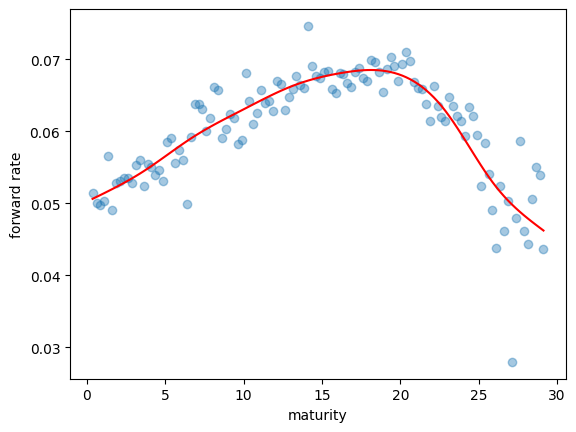

In [131]:
fig, ax = plt.subplots()
ax.scatter(T[1:], emp_forward, alpha=0.4);
ax.plot(T[1:], fit_gam, color='red');
ax.set_xlabel('maturity');
ax.set_ylabel('forward rate');